In [125]:
!git clone https://github.com/VassilisK2001/Grecotel-Project.git

fatal: destination path 'Grecotel-Project' already exists and is not an empty directory.


In [126]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import Trainer
from transformers import DistilBertTokenizer
from transformers import TrainingArguments, DistilBertForSequenceClassification
from datasets import Dataset
import torch
import torch.nn as nn
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [127]:

REPO_NAME = "Grecotel-Project"
filename = 'cleaned_dataset_tripadvisor-reviews_2025-11-01_14-21-09-431.json'
json_path = os.path.join(REPO_NAME, 'data', 'cleaned', filename)

df = pd.read_json(json_path, orient='records')

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19493 entries, 0 to 19492
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             19493 non-null  int64 
 1   lang           19493 non-null  object
 2   rating         19493 non-null  int64 
 3   travelDate     19466 non-null  object
 4   publishedDate  19493 non-null  object
 5   tripType       17379 non-null  object
 6   userLocation   11260 non-null  object
 7   review_text    19493 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.2+ MB


,id,lang,rating,travelDate,publishedDate,tripType,userLocation,review_text
0,1016346537,el,1,2025-07-01,2025-07-03,BUSINESS,None,Απαράδεκτο grecotel.. Απαράδεκτο! Έφτασα μετά ...
1,1015574543,en,5,2025-06-01,2025-06-28,FAMILY,None,Family vacation. I was afraid of what the acco...
2,987362026,el,3,2024-12-01,2025-01-02,COUPLES,None,Αδιαφορο. Το ξενοδοχείο χρήζει ανακαίνισης. Τα...
3,979445372,tr,1,2024-11-01,2024-11-10,FAMILY,None,Kahvaltı kuyruğu ve personelin kabalığı. Çocuk...
4,960799391,en,5,2023-08-01,2024-07-23,COUPLES,None,Place to stay in Alexandropoli. Wonderful stay...


In [128]:
# Convert data types
df['travelDate'] = pd.to_datetime(df['travelDate'], errors='coerce')
df['publishedDate'] = pd.to_datetime(df['publishedDate'], errors='coerce')

In [129]:
# Keep only relevant data
df_filtered = df[df['travelDate'] >= '2023-06-01'].copy()

# Keep only english reviews for now
df_filtered = df_filtered[df_filtered['lang'] == 'en']

# Keep only relevant columns
df_filtered = df_filtered[['id', 'review_text']]
df_filtered.head()

,id,review_text
1,1015574543,Family vacation. I was afraid of what the acco...
4,960799391,Place to stay in Alexandropoli. Wonderful stay...
5,960211568,The worst room i’ve ever stayed in Greece.. Th...
6,952565999,"Large, modern hotel on the coast, with reasona..."
8,917123208,Excellent located. Nice beach and excellent lo...


In [130]:
# Define Aspect Keywords
ASPECT_KEYWORDS = {
    "ROOM": ["room", "suite", "ac", "air conditioning", "view", "balcony", "cleaned daily", "comfortable"],
    "STAFF": ["staff", "reception", "waiter", "host" ,"hostess", "housekeeping", "concierge", "manager", "friendly", "helpful", "rude"],
    "FOOD": ["food", "restaurant", "breakfast", "buffet" ,"dinner", "bar", "ice cream", "drink", "variety", "choice", "cold"],
    "SERVICE": ["service", "room service", "customer service"],
    "FACILITIES": ["pool", "beach", "water park", "sunbed", "sun bed", "location", "view", "sea view"]
}

In [131]:
vader = SentimentIntensityAnalyzer()

def get_vader_sentiment(sentence):
    """
    Returns 'positive', 'negative', or 'neutral'
    based on the VADER compound score.
    """
    compound_score = vader.polarity_scores(sentence)['compound']
    if compound_score >= 0.05:
        return 'positive'
    elif compound_score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Main Labeling Function
def create_absa_dataset(df: pd.DataFrame, aspect_map: dict):
    """
    Iterates through reviews and sentences to build
    a programmatically labeled ABSA dataset.
    """
    labeled_data = []

    for index, row in df.iterrows():
        review_id = row['id']
        full_review_text = row['review_text']

        # Skip null reviews
        if pd.isna(full_review_text):
            continue

        # Split the review into individual sentences
        sentences = sent_tokenize(full_review_text)

        for sentence in sentences:
            sentence_lower = sentence.lower()
            found_aspects = set()

            # Check this sentence for each of our aspect keywords
            for aspect, keywords in aspect_map.items():
                for keyword in keywords:
                    if keyword in sentence_lower:
                        found_aspects.add(aspect)

            if found_aspects:
                # Get the sentiment of the sentence
                sentiment = get_vader_sentiment(sentence)

                # Add a new row for each aspect found
                for aspect in found_aspects:
                    labeled_data.append({
                        'review_id': review_id,
                        'aspect': aspect,
                        'sentence': sentence,
                        'sentiment': sentiment
                    })

    # Convert the final list into a new DataFrame
    absa_df = pd.DataFrame(labeled_data)

    # Remove duplicates
    absa_df = absa_df.drop_duplicates().reset_index(drop=True)

    return absa_df

In [132]:
df_absa = create_absa_dataset(df_filtered, ASPECT_KEYWORDS)
df_absa.info()
df_absa.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56803 entries, 0 to 56802
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  56803 non-null  int64 
 1   aspect     56803 non-null  object
 2   sentence   56803 non-null  object
 3   sentiment  56803 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.7+ MB


,review_id,aspect,sentence,sentiment
0,1015574543,ROOM,Family vacation.,neutral
1,1015574543,FOOD,I was afraid of what the accomodation would be...,positive
2,1015574543,ROOM,I was afraid of what the accomodation would be...,positive
3,1015574543,FACILITIES,I was afraid of what the accomodation would be...,positive
4,960799391,ROOM,Place to stay in Alexandropoli.,neutral


In [133]:
# Excluding neutral sentiment
df_absa = df_absa[df_absa['sentiment'] != 'neutral']
df_absa.shape

(46526, 4)

In [134]:
df_absa.groupby('aspect')['sentiment'].value_counts(normalize=True).unstack(fill_value=0) * 100

sentiment,negative,positive
aspect,,
FACILITIES,14.787554,85.212446
FOOD,13.351654,86.648346
ROOM,15.797326,84.202674
SERVICE,10.903932,89.096068
STAFF,8.672748,91.327252


/tmp/ipython-input-3508083971.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


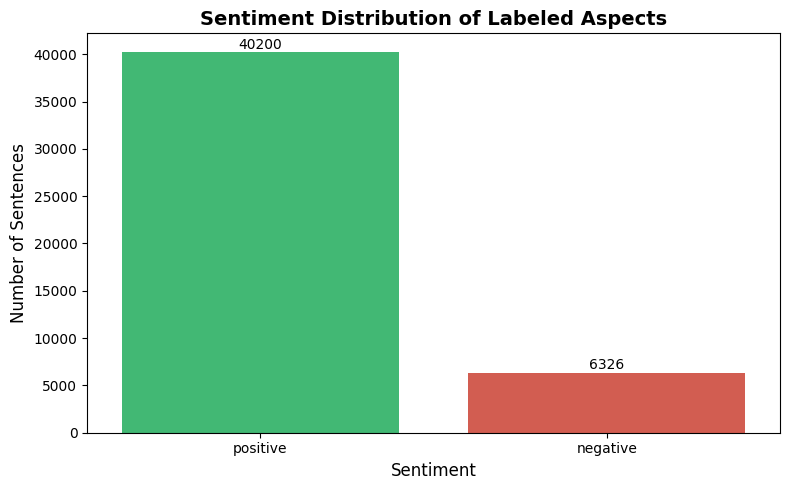

In [135]:
plt.figure(figsize=(8, 5))
sentiment_counts = df_absa['sentiment'].value_counts()

ax = sns.barplot(
    x=sentiment_counts.index,
    y=sentiment_counts.values,
    palette=['#2ecc71', '#e74c3c'],
    order=['positive', 'negative']
)

plt.title('Sentiment Distribution of Labeled Aspects', fontsize=14, weight='bold')
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

# Add count labels on top of bars
for i, count in enumerate(sentiment_counts.reindex(['positive', 'negative']).fillna(0)):
    ax.text(i, count + 50, f'{count:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipython-input-584389442.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Saved 'aspect_distribution.png'


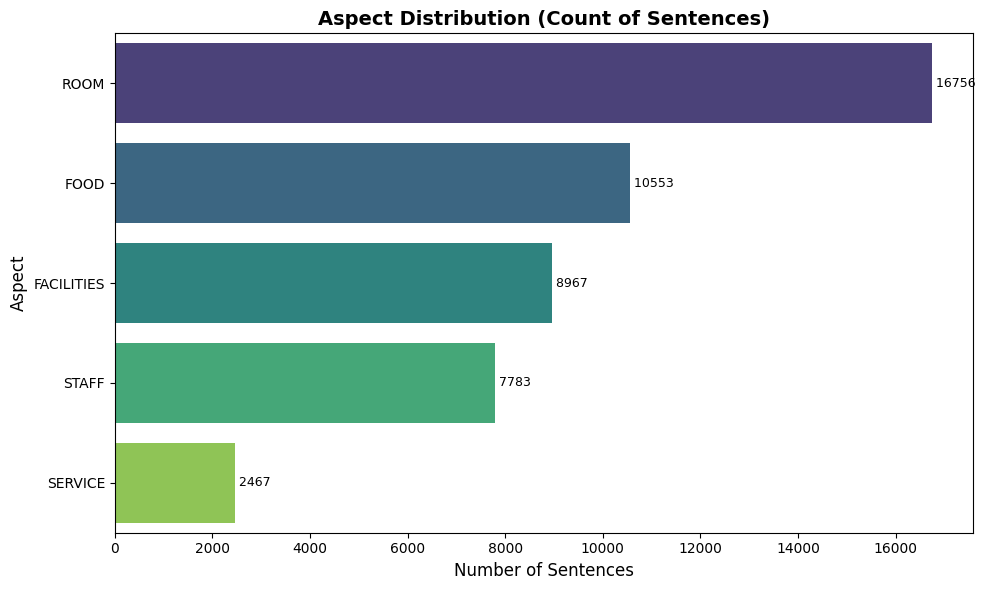

In [136]:
plt.figure(figsize=(10, 6))
aspect_counts = df_absa['aspect'].value_counts()

# Use a horizontal bar plot for easier reading
ax = sns.barplot(
    x=aspect_counts.values,
    y=aspect_counts.index,
    orient='h',
    palette='viridis'
)

plt.title('Aspect Distribution (Count of Sentences)', fontsize=14, weight='bold')
plt.xlabel('Number of Sentences', fontsize=12)
plt.ylabel('Aspect', fontsize=12)

# Add count labels to the bars
for i, count in enumerate(aspect_counts):
    ax.text(count, i, f' {count}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('aspect_distribution.png')
print("Saved 'aspect_distribution.png'")
plt.show()

In [137]:
# Calculate Sentiment Weights ---
sentiment_classes = np.unique(df_absa['sentiment'])
sentiment_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=sentiment_classes,
    y=df_absa['sentiment']
)
sentiment_weight_map = dict(zip(sentiment_classes, sentiment_weights_values))

# Calculate Aspect Weights ---
aspect_classes = np.unique(df_absa['aspect'])
aspect_weights_values = compute_class_weight(
    class_weight='balanced',
    classes=aspect_classes,
    y=df_absa['aspect']
)
aspect_weight_map = dict(zip(aspect_classes, aspect_weights_values))

# Map weights back to the DataFrame
df_absa['sentiment_weight'] = df_absa['sentiment'].map(sentiment_weight_map)
df_absa['aspect_weight'] = df_absa['aspect'].map(aspect_weight_map)

# Calculate the Final 'sample_weight'
df_absa['sample_weight'] = df_absa['sentiment_weight'] * df_absa['aspect_weight']

# Prepare data for Hugging Face
df_absa['label'] = df_absa['sentiment'].map({'positive': 1, 'negative': 0})


In [138]:
class WeightedTrainer(Trainer):
    """
    A custom trainer that applies sample weights to the loss calculation.
    (Updated to handle both training and evaluation call signatures)
    """

    # --- THIS IS THE FINAL, CORRECT SIGNATURE ---
    # It accepts *both* new arguments
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):

        # 1. Pop our custom 'sample_weight' from the inputs
        weights = inputs.pop("sample_weight")

        # 2. Get the standard model outputs (logits)
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # 3. Get the labels
        labels = inputs.get("labels")

        # 4. Calculate the per-sample loss *without* averaging
        loss_fct = nn.CrossEntropyLoss(reduction="none")
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))

        # 5. Multiply the per-sample loss by its weight
        weighted_loss = loss * weights

        # 6. Average the weighted loss
        final_loss = weighted_loss.mean()

        # 7. Return what the caller expects (this is the key)
        #    During training, return_outputs=False, so we return just the loss.
        #    During evaluation, return_outputs=True, so we return (loss, outputs).
        return (final_loss, outputs) if return_outputs else final_loss

In [139]:
# Load Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create the Dataset object from pandas DataFrame
hf_dataset = Dataset.from_pandas(df_absa[['sentence', 'aspect', 'label', 'sample_weight']])

In [140]:
# Tokenize the data
def tokenize_function(examples):
    # create the "[CLS] sentence [SEP] aspect [SEP]" format
    tokenized = tokenizer(
        examples["sentence"],
        examples["aspect"],
        truncation=True,
        padding="max_length",
        max_length=128
    )
    tokenized["label"] = examples["label"]
    tokenized["sample_weight"] = examples["sample_weight"]
    return tokenized

In [141]:
tokenized_dataset = hf_dataset.map(tokenize_function, batched=True)

columns_to_keep = ['input_ids', 'attention_mask', 'label', 'sample_weight']

columns_to_remove = [col for col in tokenized_dataset.column_names if col not in columns_to_keep]
tokenized_dataset = tokenized_dataset.remove_columns(columns_to_remove)

train_test = tokenized_dataset.train_test_split(test_size=0.2)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Load the Model
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)

# Define Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    # --- Evaluation & Saving (The Most Important Part) ---
    eval_strategy="epoch",          # Run evaluation at the end of each epoch
    save_strategy="epoch",                # Save a checkpoint at the end of each epoch
    per_device_eval_batch_size=64,        # Batch size for evaluation (can be larger)

    load_best_model_at_end=True,          # Automatically load the best model when done
    metric_for_best_model="f1",           # Use 'f1' (from compute_metrics) to find the best model
    greater_is_better=True,               # A higher F1-score is better
    save_total_limit=1,                   # Only keep the single best checkpoint

    # --- Logging & Performance ---
    logging_strategy="epoch",             # Log metrics every epoch
    fp16=True,                            # Use 16-bit mixed precision (MUCH faster on Colab GPU)
    remove_unused_columns=False,
)

Map:   0%|          | 0/46526 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [142]:

def compute_metrics(eval_pred):
    """
    Called by the Trainer at each evaluation step.
    """
    # Get the predictions (logits) and the true labels
    logits, labels = eval_pred

    # Convert logits to predictions (find the highest probability)
    predictions = np.argmax(logits, axis=-1)

    # use 'weighted' f1-score to handle class imbalance
    weighted_f1 = f1_score(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)

    return {
        'f1': weighted_f1,
        'accuracy': acc
    }

In [143]:
# Use custom trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.207000,0.109408,0.980410,0.980335


TrainOutput(global_step=2327, training_loss=0.20704517766135314, metrics={'train_runtime': 163.5927, 'train_samples_per_second': 227.516, 'train_steps_per_second': 14.224, 'total_flos': 1232609144494080.0, 'train_loss': 0.20704517766135314, 'epoch': 1.0})